In [1]:
import numpy as np
import pandas as pd
import io, sys, os
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision

from livelossplot import PlotLosses
from sklearn.metrics import classification_report, f1_score
import torchtext

from jupyterthemes import jtplot
jtplot.style()

sys.path.insert(0, '..\helpers')
from helpers import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

device = "cuda:0" if torch.cuda.is_available() else "cpu"

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../data/train.txt', sep='\t')
dataset['turn1'] = dataset['turn1'].apply(normalize)
dataset['turn2'] = dataset['turn2'].apply(normalize)
dataset['turn3'] = dataset['turn3'].apply(normalize)

test_dataset = pd.read_csv('../data/dev.txt', sep='\t')
test_dataset['turn1'] = test_dataset['turn1'].apply(normalize)
test_dataset['turn2'] = test_dataset['turn2'].apply(normalize)
test_dataset['turn3'] = test_dataset['turn3'].apply(normalize)

test1_dataset = pd.read_csv('../data/dev.txt', sep='\t')
test1_dataset['turn1'] = test1_dataset['turn1'].apply(normalize)
test1_dataset['turn2'] = test1_dataset['turn2'].apply(normalize)
test1_dataset['turn3'] = test1_dataset['turn3'].apply(normalize)
test1_dataset['label'] = test1_dataset['label'].apply(lambda x: 'not-others' if x != 'others' else 'others')

test2_dataset = pd.read_csv('../data/dev.txt', sep='\t')
test2_dataset = test2_dataset[ test2_dataset['label'] != 'others' ]
test2_dataset['turn1'] = test2_dataset['turn1'].apply(normalize)
test2_dataset['turn2'] = test2_dataset['turn2'].apply(normalize)
test2_dataset['turn3'] = test2_dataset['turn3'].apply(normalize)

tier1_dataset = pd.read_csv('../data/train.txt', sep='\t')
tier1_dataset['turn1'] = tier1_dataset['turn1'].apply(normalize)
tier1_dataset['turn2'] = tier1_dataset['turn2'].apply(normalize)
tier1_dataset['turn3'] = tier1_dataset['turn3'].apply(normalize)
tier1_dataset['label'] = tier1_dataset['label'].apply(lambda x: 'not-others' if x != 'others' else 'others')

tier2_dataset = pd.read_csv('../data/train.txt', sep='\t')
tier2_dataset = tier2_dataset[ tier2_dataset['label'] != 'others' ]
tier2_dataset['turn1'] = tier2_dataset['turn1'].apply(normalize)
tier2_dataset['turn2'] = tier2_dataset['turn2'].apply(normalize)
tier2_dataset['turn3'] = tier2_dataset['turn3'].apply(normalize)

In [3]:
label_tokenizer = Tokenizer(num_words=None, filters='')
label_tokenizer.fit_on_texts(dataset['label'].tolist())

label1_tokenizer = Tokenizer(num_words=None, filters='')
label1_tokenizer.fit_on_texts(tier1_dataset['label'].tolist())

label2_tokenizer = Tokenizer(num_words=None, filters='')
label2_tokenizer.fit_on_texts(tier2_dataset['label'].tolist())

with open('../_files/corpus.txt', 'r', encoding='utf8') as f:
    corpus = f.readlines()
    corpus = [line.strip() for line in corpus]
    tokenizer = Tokenizer(num_words=None, filters='')
    tokenizer.fit_on_texts(corpus)

t1_data, t1_turn1_len, t1_turn2_len, t1_turn3_len = make_tensors(tier1_dataset, tokenizer, label1_tokenizer)
t1_label_index = dict([[v-1,k] for k,v in label1_tokenizer.word_index.items()])

t2_data, t2_turn1_len, t2_turn2_len, t2_turn3_len = make_tensors(tier2_dataset, tokenizer, label2_tokenizer)
t2_label_index = dict([[v-1,k] for k,v in label2_tokenizer.word_index.items()])

te1_data, te1_turn1_len, te1_turn2_len, te1_turn3_len = make_tensors(test1_dataset, tokenizer, label1_tokenizer)
te2_data, te2_turn1_len, te2_turn2_len, te2_turn3_len = make_tensors(test2_dataset, tokenizer, label2_tokenizer)

data, turn1_len, turn2_len, turn3_len = make_tensors(dataset, tokenizer, label_tokenizer)
te_data, te_turn1_len, te_turn2_len, te_turn3_len = make_tensors(test_dataset, tokenizer, label_tokenizer)
label_index = dict([[v-1,k] for k,v in label_tokenizer.word_index.items()])


In [4]:
custom_embeddings = get_embedding_matrix(tokenizer.word_index, 'custom-.txt', 100).float()

In [5]:
fasttext_embeddings = get_embedding_matrix(tokenizer.word_index, 'vectors_without_emoji.txt', 300).float()

In [6]:
class Model(nn.Module):
    def __init__(self, fasttext_matrix, labels, num_classes, custom_matrix=None, residual=False):
        super(Model, self).__init__()
        
        self.fasttext = nn.Embedding(
            fasttext_matrix.shape[0],
            fasttext_matrix.shape[1],
            padding_idx = 0
        ).from_pretrained(fasttext_matrix, freeze=False)
        
        self.custom_vectors_used = False if custom_matrix is None else True
        
        if self.custom_vectors_used:
            self.custom = nn.Embedding(
                custom_matrix.shape[0],
                custom_matrix.shape[1],
                padding_idx = 0
            ).from_pretrained(custom_matrix, freeze=False)
        
        embedding_dims = fasttext_matrix.shape[1] if custom_matrix is None else fasttext_matrix.shape[1] + custom_matrix.shape[1]
        self.residual = residual
        def lstm():
            return nn.LSTM(
                    embedding_dims,
                    embedding_dims * 2,
                    num_layers = 2,
                    dropout = 0.5,
                    bidirectional = True,
                    batch_first = True
                )
        def residual_lstm():
            return nn.LSTM(
                    embedding_dims,
                    embedding_dims * 2,
                    num_layers = 2,
                    dropout = 0.5,
                    bidirectional = True,
                    batch_first = True
                )
        
        self.bi_lstm1 = lstm()
        self.bi_lstm2 = lstm()
        self.bi_lstm3 = lstm() 
        if self.residual:
            self.bi_lstm1_ = residual_lstm()
            self.bi_lstm2_ = residual_lstm()
            self.bi_lstm3_ = residual_lstm() 
        
        self.final = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(
                embedding_dims * 12,
                int(embedding_dims * 3)
            ),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_dims * 3), num_classes)
        )
        
    def forward(self, turn1, turn2, turn3):
        if self.custom_vectors_used:
            turn1_embeddings = torch.cat((self.fasttext(turn1), self.custom(turn1)), 2)
            turn2_embeddings = torch.cat((self.fasttext(turn2), self.custom(turn2)), 2)
            turn3_embeddings = torch.cat((self.fasttext(turn3), self.custom(turn3)), 2)
        else:
            turn1_embeddings = self.fasttext(turn1)
            turn2_embeddings = self.fasttext(turn2)
            turn3_embeddings = self.fasttext(turn3)
        
        if self.residual:
            _out = torch.cat(
                (self.bi_lstm1(turn1_embeddings)[0][:, -1, :] + self.bi_lstm1_(turn1_embeddings)[0][:, -1, :],
                self.bi_lstm2(turn2_embeddings)[0][:, -1, :] + self.bi_lstm2_(turn2_embeddings)[0][:, -1, :],
                self.bi_lstm3(turn3_embeddings)[0][:, -1, :] + self.bi_lstm3_(turn3_embeddings)[0][:, -1, :]), 1)
        else:
            _out = torch.cat(
                (self.bi_lstm1(turn1_embeddings)[0][:, -1, :],
                 self.bi_lstm2(turn2_embeddings)[0][:, -1, :],
                 self.bi_lstm3(turn3_embeddings)[0][:, -1, :]), 1)
        
        out = self.final(_out)
        return out

In [7]:
# t1_tensor_dataset = torch.utils.data.TensorDataset(torch.tensor(t1_data.clone().detach(), dtype=torch.long))
t1_train, t1_test = torch.utils.data.random_split(t1_data, (int(0.8*len(t1_data)), len(t1_data) - (int(0.8*len(t1_data)))))

t1_train_batches = torch.utils.data.DataLoader(
    t1_data,
#     t1_train,
    batch_size = 32,
    shuffle = True,
    pin_memory = False,
    num_workers = 8
)

t1_test_batches = torch.utils.data.DataLoader(
    te1_data,
    batch_size = 16,
    shuffle = True,
    pin_memory = True,
    num_workers = 8)

In [8]:
# t2_tensor_dataset = torch.utils.data.TensorDataset(torch.tensor(t2_data.clone().detach(), dtype=torch.long))
t2_train, t2_test = torch.utils.data.random_split(t2_data, (int(0.8*len(t2_data)), len(t2_data) - (int(0.8*len(t2_data)))))

t2_train_batches = torch.utils.data.DataLoader(
#     t2_tensor_dataset,
    t2_data,
    batch_size = 64,
    shuffle = True,
    pin_memory = True,
    num_workers = 8
)

t2_test_batches = torch.utils.data.DataLoader(
    te2_data,
    batch_size = 64,
    shuffle = True,
    pin_memory = True,
    num_workers = 8)

In [9]:
train_batches = torch.utils.data.DataLoader(
    data,
    batch_size = 64,
    shuffle = True,
#     pin_memory = True,
    num_workers = 8
)

test_batches = torch.utils.data.DataLoader(
    te_data,
    batch_size = 64,
    shuffle = True,
#     pin_memory = True,
    num_workers = 8)

In [10]:
def train(epochs, model, loss, optimizer, turn_lens, te_turn_lens, train_batches, test_batches=None, tensor_dataset=False, live_loss=PlotLosses(), scheduler=None):
    for epoch in range(epochs):
        if scheduler is not None:
            scheduler.step()
        model.train()
        train_errors = []
        for batch in tqdm(train_batches):
            if tensor_dataset:
                batch = batch[0]
            max1 = torch.max(batch.narrow(1, 0, 1)).item()
            max2 = torch.max(batch.narrow(1, 1, 1)).item()
            max3 = torch.max(batch.narrow(1, 2, 1)).item()
            
            t1 = batch.narrow(1, 3 + turn_lens[0] - max1, max1).to(device)
            t2 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] - max2, max2).to(device)
            t3 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2] - max3, max3).to(device)

            y = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2], 1).to(device)

            pred = model(t1, t2, t3)
            error = loss(pred, y.view(-1))

            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            train_errors.append(error.data.item())

        model.eval()
        predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()
        test_predictions = []
        test_actual = []
        test_errors = []
        for batch in test_batches:
            max1 = torch.max(batch.narrow(1, 0, 1)).item()
            max2 = torch.max(batch.narrow(1, 1, 1)).item()
            max3 = torch.max(batch.narrow(1, 2, 1)).item()

            t1 = batch.narrow(1, 3 + te_turn_lens[0] - max1, max1).to(device)
            t2 = batch.narrow(1, 3 + te_turn_lens[0] + te_turn_lens[1] - max2, max2).to(device)
            t3 = batch.narrow(1, 3 + te_turn_lens[0] + te_turn_lens[1] + te_turn_lens[2] - max3, max3).to(device)

            y = batch.narrow(1, 3 + te_turn_lens[0] + te_turn_lens[1] + te_turn_lens[2], 1).to(device)

            pred = model(t1, t2, t3)
            test_predictions.append(predict(pred))
            test_errors.append(loss(pred, y.view(-1)).data.item())    # get loss
            test_actual.append(y.cpu().numpy())

        train_predictions = []
        train_actual = []
        for batch in train_batches:
    #         batch = batch[0]
            max1 = torch.max(batch.narrow(1, 0, 1)).item()
            max2 = torch.max(batch.narrow(1, 1, 1)).item()
            max3 = torch.max(batch.narrow(1, 2, 1)).item()

            t1 = batch.narrow(1, 3 + turn_lens[0] - max1, max1).to(device)
            t2 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] - max2, max2).to(device)
            t3 = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2] - max3, max3).to(device)

            y = batch.narrow(1, 3 + turn_lens[0] + turn_lens[1] + turn_lens[2], 1).to(device)
            pred = model(t1, t2, t3)
            train_predictions.append(predict(pred))
            train_actual.append(y.cpu().numpy())

        live_loss.update({
            'train_loss': torch.tensor(train_errors).mean(),
            'test_loss': torch.tensor(test_errors).mean() if test_batches is not None else None,
            'train_f1': f1_score(np.concatenate(train_actual), np.concatenate(train_predictions), average='weighted'),
            'test_f1': f1_score(np.concatenate(test_actual), np.concatenate(test_predictions), average='weighted') if test_batches is not None else None,
        })
        live_loss.draw()
        
    return live_loss

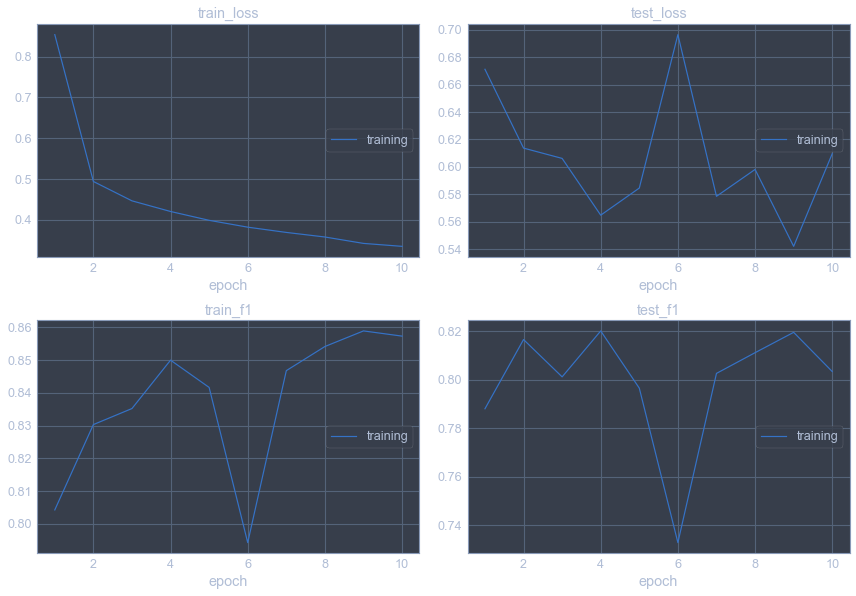

train_loss:
training   (min:    0.335, max:    0.854, cur:    0.335)

test_loss:
training   (min:    0.542, max:    0.696, cur:    0.610)

train_f1:
training   (min:    0.794, max:    0.859, cur:    0.857)

test_f1:
training   (min:    0.733, max:    0.820, cur:    0.803)


In [11]:
epochs = 10
labels = list(label_tokenizer.word_index.keys())
model = Model(fasttext_embeddings, labels, len(labels), custom_matrix=None, residual=True)
loss = nn.CrossEntropyLoss(weight=get_class_weights(dataset['label'], labels).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)
model.to(device)

train(
    epochs,
    model,
    loss,
    optimizer,
    (turn1_len, turn2_len, turn3_len),
    (te_turn1_len, te_turn2_len, te_turn3_len),
    train_batches,
    test_batches,
    scheduler=scheduler
).draw()

torch.save(model.state_dict(), 'model')

In [12]:
t1_epochs = 5
labels = list(label_tokenizer.word_index.keys())

t1_model = Model(fasttext_embeddings, custom_embeddings, len(tier1_dataset['label'].unique()))
t1_loss = nn.CrossEntropyLoss(weight=get_class_weights(tier1_dataset['label']).to(device))
t1_optimizer = torch.optim.Adam(t1_model.parameters(), lr=0.0001, amsgrad=True)
t1_scheduler = torch.optim.lr_scheduler.ExponentialLR(t1_optimizer, gamma=0.75, last_epoch=-1)
t1_model.to(device)

train(
    t1_epochs,
    t1_model,
    t1_loss,
    t1_optimizer,
    (t1_turn1_len, t1_turn2_len, t1_turn3_len),
    t1_train_batches,
    t1_test_batches,
    scheduler=t1_scheduler
).draw()

torch.save(t1_model.state_dict(), 't1_model')
t1_model.to("cpu")
del t1_model, t1_loss, t1_optimizer, t1_train_batches, t1_test_batches

TypeError: get_class_weights() missing 1 required positional argument: 'labels'

In [ ]:
t1_epochs = 4
labels = list(label_tokenizer.word_index.keys())

t1_model = Model(fasttext_embeddings, custom_embeddings, len(tier1_dataset['label'].unique()))
t1_loss = nn.CrossEntropyLoss(weight=get_class_weights(tier1_dataset['label']).to(device))
t1_optimizer = torch.optim.Adam(t1_model.parameters(), lr=0.0008, amsgrad=True)
t1_scheduler = torch.optim.lr_scheduler.ExponentialLR(t1_optimizer, gamma=0.25, last_epoch=-1)
t1_model.to(device)

train(
    t1_epochs,
    t1_model,
    t1_loss,
    t1_optimizer,
    (t1_turn1_len, t1_turn2_len, t1_turn3_len),
    (te1_turn1_len, te1_turn2_len, te1_turn3_len),
    t1_train_batches,
    t1_test_batches,
    scheduler=t1_scheduler
).draw()

torch.save(t1_model.state_dict(), 't1_model')
t1_model.to("cpu")
del t1_model, t1_loss, t1_optimizer, t1_train_batches, t1_test_batches

In [ ]:
t2_epochs = 4
labels = list(label_tokenizer.word_index.keys())

t2_model = Model(fasttext_embeddings, custom_embeddings, len(tier2_dataset['label'].unique()))
t2_loss = nn.CrossEntropyLoss(weight=get_class_weights(tier2_dataset['label']).to(device))
t2_optimizer = torch.optim.Adam(t2_model.parameters(), lr=0.0008, amsgrad=True)
t2_scheduler = torch.optim.lr_scheduler.ExponentialLR(t2_optimizer, gamma=0.20, last_epoch=-1)
t2_model.to(device)
live_loss = PlotLosses()

train(
    t2_epochs,
    t2_model,
    t2_loss,
    t2_optimizer,
    (t2_turn1_len, t2_turn2_len, t2_turn3_len),
    (te2_turn1_len, te2_turn2_len, te2_turn3_len),
    t2_train_batches,
    t2_test_batches,
    scheduler=t2_scheduler
).draw()

torch.save(t2_model.state_dict(), 't2_model')
t2_model.to("cpu")
del t2_model, t2_loss, t2_optimizer, t2_scheduler, t2_train_batches, t2_test_batches

In [ ]:
dataset = pd.read_csv('../data/testwithoutlabels.txt', sep='\t')

dataset['turn1'] = dataset['turn1'].apply(normalize)
dataset['turn2'] = dataset['turn2'].apply(normalize)
dataset['turn3'] = dataset['turn3'].apply(normalize)

turn1 = [[len(x)] + x for x in tokenizer.texts_to_sequences(dataset['turn1'].tolist())]
turn2 = [[len(x)] + x for x in tokenizer.texts_to_sequences(dataset['turn2'].tolist())]
turn3 = [[len(x)] + x for x in tokenizer.texts_to_sequences(dataset['turn3'].tolist())]

len1 = torch.stack([torch.tensor(x[0]).long() for x in turn1]).unsqueeze(1)
len2 = torch.stack([torch.tensor(x[0]).long() for x in turn2]).unsqueeze(1)
len3 = torch.stack([torch.tensor(x[0]).long() for x in turn3]).unsqueeze(1)

turn1 = torch.stack([torch.tensor(x).long() for x in pad_sequences([x[1:] for x in turn1])])
turn2 = torch.stack([torch.tensor(x).long() for x in pad_sequences([x[1:] for x in turn2])])
turn3 = torch.stack([torch.tensor(x).long() for x in pad_sequences([x[1:] for x in turn3])])

eval_data = torch.cat((len1, len2, len3,
                turn1, turn2, turn3), dim=1)
turn1_len, turn2_len, turn3_len = turn1.shape[1], turn2.shape[1], turn3.shape[1]

eval_tensors = torch.utils.data.TensorDataset(torch.tensor(eval_data.clone().detach(), dtype=torch.long))
batches = torch.utils.data.DataLoader(
    eval_tensors,
    batch_size = 128,
    pin_memory = True,
    num_workers = 8
)

predictions = []
predict = lambda x: torch.argmax(x, dim=1).cpu().numpy()

In [ ]:
t1_model = Model(fasttext_embeddings, custom_embeddings, len(tier1_dataset['label'].unique()))
t1_model.load_state_dict(torch.load('t1_model'))
t1_model.to(device)

t1_model.eval()
for batch in tqdm(batches):
    batch = batch[0]
    max1 = torch.max(batch.narrow(1, 0, 1)).item()
    max2 = torch.max(batch.narrow(1, 1, 1)).item()
    max3 = torch.max(batch.narrow(1, 2, 1)).item()

    t1 = batch.narrow(1, 3 + turn1_len - max1, max1).to(device)
    t2 = batch.narrow(1, 3 + turn1_len + turn2_len - max2, max2).to(device)
    t3 = batch.narrow(1, 3 + turn1_len + turn2_len + turn3_len - max3, max3).to(device)

    pred = t1_model(t1, t2, t3)
    predictions = predictions + list(predict(pred))

dataset['t1_label'] = [t1_label_index[x] for x in predictions]

In [ ]:
labels = list(label_tokenizer.word_index.keys())

t2_model = Model(fasttext_embeddings, custom_embeddings, labels, len(labels))
t2_model.load_state_dict(torch.load('model'))
t2_model.to(device)
t2_model.eval()
predictions = []
for batch in tqdm(batches):
    batch = batch[0]
    max1 = torch.max(batch.narrow(1, 0, 1)).item()
    max2 = torch.max(batch.narrow(1, 1, 1)).item()
    max3 = torch.max(batch.narrow(1, 2, 1)).item()

    t1 = batch.narrow(1, 3 + turn1_len - max1, max1).to(device)
    t2 = batch.narrow(1, 3 + turn1_len + turn2_len - max2, max2).to(device)
    t3 = batch.narrow(1, 3 + turn1_len + turn2_len + turn3_len - max3, max3).to(device)

    pred = t2_model(t1, t2, t3)
    predictions = predictions + list(predict(pred))

dataset['label'] = [label_index[x] for x in predictions]
# dataset['label'] = [x[1]['t2_label'] if x[1]['t1_label'] == 'not-others' else x[1]['t1_label'] for x in dataset.iterrows()]
dataset[ ['id', 'turn1', 'turn2', 'turn3', 'label'] ].to_csv('test.txt', sep='\t', index=False)

In [ ]:
dataset[ ['id', 'turn1', 'turn2', 'turn3', 'label'] ]

In [ ]:
label_tokenizer.word_index

In [ ]:
dataset

In [ ]:
t2_turn1_len, t2_turn2_len, t2_turn3_len

In [ ]:
well i know he likes me it's clearly  shown

In [ ]:
t2_data.shape

In [ ]:
len([0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    2,   13,   58,    0])

In [ ]:
tier1_dataset

In [ ]:
label2_tokenizer.word_index